# Predicting Diatom concentration with functional regression based on the oceanographic boxes (spatial means)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, LocalLinearRegressionHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from skfda.ml.regression import HistoricalLinearRegression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

from tqdm import tqdm

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi

np.warnings.filterwarnings('ignore') # For the nan mean warning


## Datasets Preparation

In [2]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, regions, name, inputs_names):
    
    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
    
    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    inputs = []
    
    for i in inputs_names:
        inputs.append(dataset2[i].to_numpy().reshape(*dataset2[i].to_numpy().shape[:1],-1))

    inputs = np.array(inputs)

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    targets = np.delete(targets,indx,axis=0)

    # Splitting in years
    inputs = np.split(inputs,len(np.unique(dataset.time_counter.dt.year)),axis=1)
    targets = np.split(targets,len(np.unique(dataset.time_counter.dt.year)),axis=0)

    # Means
    inputs = np.nanmean(inputs,axis=0)
    targets = np.nanmean(targets,axis=0)

    x =  np.tile(dataset2.x, len(dataset2.y))
    y =  np.tile(np.repeat(dataset2.y, len(dataset2.x)),1)

    indx = np.where((~np.isnan(targets).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,:,indx[0]]
    targets = targets[:,indx[0]]

    regions = np.tile(np.ravel(regions), len(dataset.time_counter))
    regions = regions[indx[0]]

    return(inputs, targets, indx, regions)


## File Creation

In [3]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [4]:
def regressor (inputs, targets, j, r_inputs):

    # Printing of the correlation coefficients
    temp_inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp_inputs = temp_inputs.transpose()
    temp_targets = np.ravel(targets)

    r_inputs[j] = np.round(r_regression(temp_inputs,temp_targets),2)

    # Scaling the inputs
    scaler_inputs = make_column_transformer((StandardScaler(), np.arange(0,len(inputs))))
    temp_inputs = scaler_inputs.fit_transform(temp_inputs)
    temp_inputs = temp_inputs.transpose()
    inputs = np.reshape(temp_inputs,(len(inputs),inputs.shape[1],inputs.shape[2]))   
    
    # Scaling the targets
    scaler_targets = StandardScaler()
    temp_targets = np.expand_dims(temp_targets,-1)
    temp_targets = scaler_targets.fit_transform(temp_targets)
    targets = temp_targets.reshape(targets.shape)

    # Final transformations
    inputs = np.transpose(inputs,axes=(2,1,0))
    targets = targets.transpose()
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets[0])))
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    ## Smoothing
    # targets = targets.to_basis(FourierBasis(n_basis=10))
    kernel_estimator = LocalLinearRegressionHatMatrix(bandwidth=1)
    smoother = KernelSmoother(kernel_estimator=kernel_estimator)
    inputs = smoother.fit_transform(inputs)

    model = HistoricalLinearRegression(n_intervals=3,lag=74)
    regr = model.fit(inputs,targets)

    return(regr,scaler_inputs,scaler_targets,smoother,r_inputs)


## Scaling

In [5]:
def scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother):

    # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp = temp.transpose()
    temp = scaler_inputs.transform(temp)
    temp = temp.transpose()        
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2]))
        
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets)))

    inputs = smoother.transform(inputs)

    predictions = regr.predict(inputs)

    # Post-processing of predictions
    predictions = np.array(predictions.to_grid(np.arange(0,len(targets))).data_matrix)
    predictions = np.squeeze(predictions,2)

    # Scaling the predictions
    temp = np.ravel(predictions)
    temp = np.expand_dims(temp,axis=-1)
    temp = scaler_targets.inverse_transform(temp)
    predictions = temp.reshape(predictions.shape)
    predictions = predictions.transpose()

    return(predictions)


## Scatter Plot

In [6]:
def scatter_plot(dates,targets, predictions, name):

    indx = pd.DatetimeIndex(dates[0:75]) # From the first year

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots()

    scatter = ax.scatter(targets,predictions, s = 10, c= indx.month)

    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()])]

    # plot fitted y = m*x + b
    ax.axline(xy1=(0, b), slope=m, color='r')

    ax.set_xlabel('targets')
    ax.set_ylabel('predictions')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(name)

    plt.show()

    return(m)

## Pre-training

In [7]:
def pre_training(dataset,dataset2,boxes,regions0,name,inputs_names):

    np.warnings.filterwarnings('ignore') # For the nan mean warning

    regions_indiv_t = np.zeros((len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))
    regions_indiv_d = np.zeros((len(inputs_names),len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))

    ds = dataset
    ds2 = dataset2

    for i in range(0, len(np.unique(ds.time_counter.dt.year))):

        dataset = ds.sel(time_counter = slice(str(np.unique(ds.time_counter.dt.year)[i]), str(np.unique(ds.time_counter.dt.year)[i])))
        dataset2 = ds2.sel(time_counter = slice(str(np.unique(ds2.time_counter.dt.year)[i]), str(np.unique(ds2.time_counter.dt.year)[i])))

        inputs, targets, indx, _ = datasets_preparation(dataset, dataset2, regions0, name, inputs_names)

        regions1 = np.ravel(regions0)[indx]

        for j in range (0,len(boxes)):

            temp = xr.where(regions1==j, inputs, np.nan)
            regions_indiv_d[:,:,i,j] = np.nanmean(temp,axis=2)

            temp = xr.where(regions1==j, targets, np.nan)
            regions_indiv_t[:,i,j] = np.nanmean(temp,axis=1)

    return(regions_indiv_d,regions_indiv_t,indx)


## Plotting (Mean Values)

In [8]:
def plotting_mean_values(dates,boxes,targets,predictions,r_train,rms_train,slope_train,category,units,region,boxnames):

    years = np.unique(dates.year)
    
    ticks = []
    for i in range (0,targets.shape[0]*targets.shape[1],targets.shape[0]):
        ticks.append(i)

    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')
    predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],predictions.shape[2]), order = 'F')
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    targets_masked[ticks] = np.ma.masked
    predictions_masked[ticks] = np.ma.masked

    for i in range (0,len(boxes)):

        fig, _ = plt.subplots(figsize=(19,5))

        temp = pd.DataFrame(np.vstack((r_train[i],rms_train[i],slope_train[i])).transpose(),index=[boxnames[i]],columns=['r','rms','slope'])
        display(temp)

        plt.plot(targets_masked[:,i], label = 'targets')
        plt.plot(predictions_masked[:,i], label = 'predictions')
        plt.xlabel('Years')
        plt.xticks(ticks,years)
        plt.suptitle('Mean '+category + ' ' +units + ' (15 Feb - 30 Apr) ' + region + ' ' + boxnames[i])
        plt.legend()

        plt.show()


## Post-Training

In [9]:
def post_training(dates,boxes,targets,predictions,category,units,region,boxnames):

    r_train = np.full(len(boxes),np.nan)
    rms_train = np.full(len(boxes),np.nan)
    slope_train = np.full(len(boxes),np.nan)

    for i in range (0,len(boxes)):

        r_train[i] = np.round(np.corrcoef(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))[0][1],3)
        rms_train[i] = rmse(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))
        m,_ = np.polyfit(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]), deg=1)
        slope_train[i] = np.round(m,3)
    
    plotting_mean_values(dates,boxes,targets,predictions,r_train,rms_train,slope_train,category,units,region,boxnames)

    return(r_train,rms_train,slope_train)


## Plotting (regions)

In [10]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

## Initiation

In [11]:
name = 'Diatom'
units = '[mmol m-2]'
category = 'Concentrations'

if name == 'Diatom':
    inputs_names = ['Summation_of_solar_radiation','Mean_wind_speed','Mean_air_temperature']
else:
    inputs_names = ['Summation_of_solar_radiation','Mean_air_temperature','Mean_pressure', 'Mean_precipitation', 'Mean_specific_humidity']

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')


## Regions

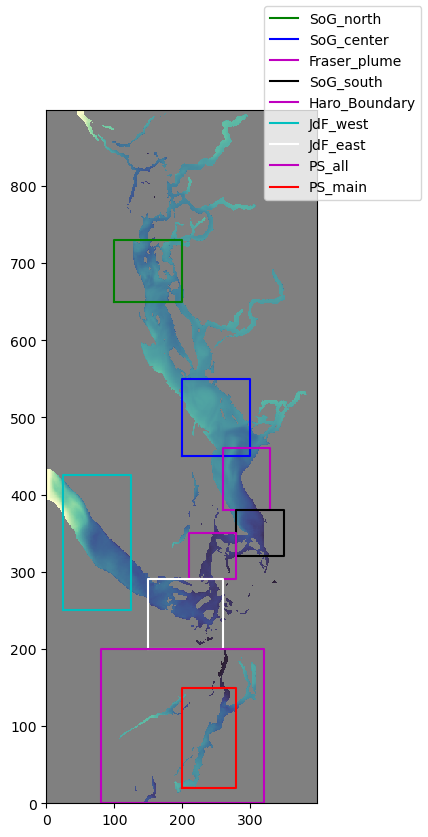

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(ds['Diatom'][0], cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['SoG_north','SoG_center','Fraser_plume','SoG_south', 'Haro_Boundary', 'JdF_west', 'JdF_east', 'PS_all', 'PS_main']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(ds.y),len(ds.x)),np.nan)

for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])

# # Low resolution
# temp = []

# for i in boxes:
#     temp.append([x//5 for x in i])

# boxes = temp

## Training

In [13]:
# Low resolution

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

# regions0 = regions0.isel(y=(np.arange(regions0.y[0], regions0.y[-1], 5)), 
#     x=(np.arange(regions0.x[0], regions0.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

years = np.unique(dataset.time_counter.dt.year)

r_inputs = np.zeros((len(boxnames), len(inputs_names)))

inputs,targets,indx = pre_training(dataset,dataset2,boxes,regions0,name,inputs_names)

regr_all = []
scaler_inputs_all = []
scaler_targets_all = []
smoother_all = []

predictions = np.full(targets.shape,np.nan)

for i in range (0,len(boxes)):

    inputs2 = inputs[:,:,:,i] # inputs of the i cluster
    targets2 = targets[:,:,i] # targets of the i cluster
    regr, scaler_inputs,scaler_targets,smoother,r_inputs = regressor(inputs2,targets2,i,r_inputs)

    scaler_inputs_all.append(scaler_inputs)
    scaler_targets_all.append(scaler_targets)
    smoother_all.append(smoother)

    regr_all.append(regr)

    predictions[:,:,i] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets2,scaler_targets_all[i],smoother_all[i]) # putting them in the right place

print('Metrics between input features and '+name)
temp = pd.DataFrame(r_inputs,index=boxnames, columns=['Summation of solar radiation','Mean wind speed','Mean air temperature'])
display(temp)


Metrics between input features and Diatom


,Summation of solar radiation,Mean wind speed,Mean air temperature
SoG_north,0.42,-0.20,0.47
SoG_center,0.41,-0.25,0.37
Fraser_plume,0.45,-0.24,0.41
SoG_south,0.52,-0.32,0.44
Haro_Boundary,0.51,-0.31,0.47
JdF_west,0.51,-0.24,0.49
JdF_east,0.53,-0.12,0.47
PS_all,0.47,-0.25,0.41
PS_main,0.54,-0.29,0.43


In [26]:
targets_x = xr.DataArray(targets)
predictions_x = xr.DataArray(predictions)

In [27]:
targets_x

<xarray.DataArray (dim_0: 75, dim_1: 14, dim_2: 9)> Size: 76kB
array([[[0.17145612, 0.1504278 , 0.18541775, ..., 0.22727276,
         0.17791357, 0.18742962],
        [0.16748327, 0.15032432, 0.19208707, ..., 0.22817196,
         0.20430127, 0.24621069],
        [0.18933559, 0.17846554, 0.20777324, ..., 0.23440716,
         0.20392176, 0.22011357],
        ...,
        [0.19964277, 0.20899284, 0.25544842, ..., 0.23804448,
         0.2566463 , 0.26916011],
        [0.18255737, 0.15590959, 0.18167981, ..., 0.18489287,
         0.17976859, 0.18764074],
        [0.1838872 , 0.18412694, 0.21779481, ..., 0.19539514,
         0.20090848, 0.20868009]],

       [[0.17734943, 0.14896785, 0.18069739, ..., 0.22559309,
         0.17544879, 0.18468686],
        [0.16698061, 0.1494294 , 0.1905242 , ..., 0.2233305 ,
         0.200605  , 0.24190692],
        [0.19930197, 0.19158332, 0.2191415 , ..., 0.24170939,
         0.21111996, 0.22348291],
...
        [0.54367442, 0.33771694, 0.42163904, ..., 0.51774821,
         0.56801272, 0.475632  ],
        [0.54189508, 0.45689571, 0.58782079, ..., 0.54046834,
         0.61909021, 0.60949802],
        [0.2512133 , 0.24276702, 0.28955509, ..., 0.30679233,
         0.31018369, 0.38768855]],

       [[0.39144487, 0.35663937, 0.36301662, ..., 0.44501383,
         0.42040818, 0.54998277],
        [0.45828958, 0.22837845, 0.3399206 , ..., 0.39313509,
         0.41949981, 0.46113288],
        [0.62272896, 0.56982639, 0.52179411, ..., 0.45309761,
         0.397511  , 0.41990639],
        ...,
        [0.51995352, 0.32971148, 0.41435825, ..., 0.49895771,
         0.48140915, 0.45491102],
        [0.6233558 , 0.55870717, 0.68540376, ..., 0.6587937 ,
         0.62309787, 0.56350938],
        [0.23518027, 0.23437853, 0.26870845, ..., 0.29906812,
         0.31074739, 0.43688411]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

## Heatmaps

In [ ]:
for i in range(0,len(inputs_names)):

    fig, axs = plt.subplots(1,len(boxes), figsize = (28,6), layout='constrained')

    for j in range(0,len(boxes)):

        temp = regr_all[j].coef_
        coeff = temp.data_matrix
        coeff = np.where(coeff==0,np.nan,coeff)

        if j==0: #first time for this input feature

            vmin = np.nanmin(coeff[0,:,:,i])
            vmax = np.nanmax(coeff[0,:,:,i])

        h = axs[j].imshow(coeff[0,:,:,i], cmap='bwr',aspect='auto', vmin=-np.maximum(np.abs(vmin),vmax), vmax=np.maximum(np.abs(vmin),vmax))
        axs[j].set_ylim(axs[j].get_ylim()[::-1])
        cbar = fig.colorbar(h)
        axs[j].set_title('Region ' +boxnames[j])
        axs[j].set_xlabel('Day')
        axs[j].set_ylabel('Day')
        fig.suptitle(inputs_names[i])


## Time-series (Training)

In [ ]:
dates = pd.DatetimeIndex(dataset['time_counter'].values)
indx2 = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx2]

r_train,rms_train,slope_train = post_training(dates,boxes,targets,predictions,units,category,' ',boxnames)

season = np.mean(targets,axis=1)

season_train = np.tile(season,len(np.unique(dates.year))) # Broadcasting season to all training years
season_train = np.reshape(season_train,targets.shape)

plt.plot(season)
plt.legend(boxnames)
plt.suptitle('Long-term seasonalities (2007-2020, targets)')
plt.show()

season2 = np.mean(predictions,axis=1)

plt.plot(season2)
plt.legend(boxnames)
plt.suptitle('Long-term seasonalities (2007-2020, predictions)')
plt.show()

r_train_season,_,slope_train_season = post_training(dates,boxes,targets-season_train,predictions-season_train,units,category,'(removed seasonality)',boxnames)


## Other Years

In [ ]:
dataset = ds.sel(time_counter = slice('2021', '2024'))
dataset2 = ds2.sel(time_counter = slice('2021', '2024'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
indx = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx]

years = np.unique(dataset.time_counter.dt.year)

inputs,targets,indx = pre_training(dataset,dataset2,boxes,regions0,name,inputs_names)

season_test = np.tile(season,len(years)) # Broadcasting season to all testing years
season_test = np.reshape(season_test,(targets.shape[0],len(years),len(boxes)))

predictions = np.full(targets.shape,np.nan)

for i in range (0,len(boxes)):

    inputs2 = inputs[:,:,:,i] # inputs of the i cluster
    targets2 = targets[:,:,i] # targets of the i cluster
    predictions[:,:,i] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets2,scaler_targets_all[i],smoother_all[i]) # putting them in the right place

season_test = np.tile(season,len(years)) # Broadcasting season to all testing years
season_test = np.reshape(season_test,(targets.shape[0],len(years),len(boxes)))


## Time-series (Testing)

In [ ]:
r_test,rms_test,slope_test = np.zeros(len(boxes)), np.zeros(len(boxes)), np.zeros(len(boxes))

r_test_season, slope_test_season = np.zeros(len(boxes)), np.zeros(len(boxes))

targets_sum, predictions_sum = np.zeros((len(boxes),len(years))), np.zeros((len(boxes),len(years)))

targets_mean, predictions_mean = np.zeros((len(boxes),len(years))), np.zeros((len(boxes),len(years)))

targets_diff, predictions_diff = np.zeros((len(boxes),targets.shape[0],len(years))), np.zeros((len(boxes),targets.shape[0],len(years)))

rss = np.zeros(len(boxes))

r_test_season,_,slope_test_season = post_training(dates,boxes,targets-season_test,predictions-season_test,units,category,'(removed Seasonality)',boxnames)

for i in range (0,len(boxes)):

    r_test[i] = np.round(np.corrcoef(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))[0][1],3)
    rms_test[i] = rmse(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))
    m,_ = np.polyfit(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]), deg=1)
    slope_test[i] = np.round(m,3)

    rss[i] = np.sum((np.ravel(targets[:,:,i])-np.ravel(predictions[:,:,i]))**2) # Similar to rms, is not affected by the seasonality

    for j in range (0, len(years)):

        targets_sum[i,j] = np.sum(targets[:,j,i]-season_test[:,j,i])
        predictions_sum[i,j] = np.sum(predictions[:,j,i]-season_test[:,j,i])

        targets_mean[i,j] = np.mean(targets[:,j,i]-season_test[:,j,i])
        predictions_mean[i,j] = np.mean(predictions[:,j,i]-season_test[:,j,i])

        mean = np.mean(targets[:,j,i])
        std = np.std(targets[:,j,i])
        diff = mean + 1*std

        targets_diff[i,:,j] = np.where(targets[:,j,i]>diff,targets[:,j,i], np.nan)
        predictions_diff[i,:,j] = np.where(predictions[:,j,i]>diff,predictions[:,j,i], np.nan)

targets_diff = np.reshape(targets_diff,(len(boxes),targets.shape[0]*targets.shape[1]), order = 'F')
predictions_diff = np.reshape(predictions_diff,(len(boxes),targets.shape[0]*targets.shape[1]), order = 'F')

for i in range (0, len(targets_diff)):
        plt.figure()
        plt.plot(targets_diff[i])
        plt.plot(predictions_diff[i])


## Saving

In [ ]:
path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg_boxes_s/'

os.makedirs(path, exist_ok=True)
with lzma.open(path + 'regr_all.xz', 'wb') as f:
    
    dill.dump(regr, f)

with open(path + 'train_metrics.pkl', 'wb') as f:
    dill.dump([r_train,rms_train,slope_train,r_train_season,slope_train_season,season.transpose()], f)

with open(path + 'test_metrics.pkl', 'wb') as f:
    dill.dump([r_test,rms_test,slope_test,r_test_season,slope_test_season,targets_sum,predictions_sum,targets_mean,predictions_mean,targets_diff,predictions_diff,rss], f)

with open(path + 'targets-predictions.pkl', 'wb') as f:
    dill.dump([targets,predictions], f)
